## Using a linear model to predict real estate prices
Michael Vandervelden, 2023

In [288]:
# Import requisite libraries

import asyncio
from typing import List
import httpx
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from urllib.parse import urlencode

from parsel import Selector
pd.set_option('display.max_rows', 50)

In [12]:
client = httpx.AsyncClient(
    http2=True,
    headers={
        "accept-language": "en-US,en;q=0.9",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "accept-language": "en-US;en;q=0.9",
        "accept-encoding": "gzip, deflate, br",
    },
)

Here we store the latitude and longitude values for each borough, as well as the search term strings needed for each borough. These will later be passed as parameters to the scraping/data cleaning function defined below. 

In [106]:
brooklyn_coords = {"west":-74.28887284228514,"east":-74.01902115771483,"south":40.49361654444022,"north":40.65112924425314,}
bronx_coords = {"west":-74.2075666845703, "east":-73.66786331542967, "south":40.49753808454121,"north":40.812174096474955,}
manhattan_coords = {"west":-74.24867418457029, "east":-73.70897081542967,"south":40.62357275516118,"north":40.93761504703568,}
statenisland_coords = {"west":-74.255641,"east":-74.052253,"south":40.495865,"north":40.648886,}
queens_coords =  {"west":-73.962632,"east":-73.700272,"south":40.541722,"north":40.80071,}



brooklyn_search = "Brookyln NY New New York"
bronx_search = "Bronx NY New York"
manhattan_search = "Manhattan NY New York"
statenisland_search = "Staten Island NY New York"
queens_search = "Queens NY New York"

Function to scrape and perform initial cleaning of Zillow data depending for each New York City borough 

In [107]:
def get_and_clean_borough_data(location_dict, location_name):
    BASE_HEADERS = {

        "accept-language": "en-US,en;q=0.9",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "accept-language": "en-US;en;q=0.9",
        "accept-encoding": "gzip, deflate, br",
    }

    url = "https://www.zillow.com/search/GetSearchPageState.htm?"



    # Search parameters
    parameters = {
        "searchQueryState": {
            "pagination": {},
            "usersSearchTerm": location_name,
            
            "mapBounds": location_dict,

        },
        "wants": {
            "cat1": ["listResults", "mapResults"], "cat2": ["total"]
        },
        "requestId": 2,
    }
    response = httpx.get(url + urlencode(parameters), headers=BASE_HEADERS)
    assert response.status_code == 200, "request has been blocked"
    data = response.json()
    results = response.json()["cat1"]["searchResults"]["mapResults"]
    data_list = json.dumps(results, indent=2)
    df = pd.read_json(data_list)
    
    borough_df = df.drop(df.iloc[:, 7:], axis=1)
    
    
    borough_df = borough_df.drop(columns=['zpid', 'rentalMarketingSubType','priceLabel'])
        
    
    borough_df = borough_df.dropna()
    
    borough_df['price'] = borough_df['price'].apply(lambda x: re.sub('[$,KFrom]', '', x))
    borough_df['beds'] = borough_df['beds'].apply(lambda x: int(x))
    borough_df['baths'] = borough_df['baths'].apply(lambda x: int(x))
    

    return borough_df
        

Creating a dataframe for each borough. These will be concatenated later.

In [115]:
brooklyn_df = get_and_clean_borough_data(brooklyn_coords, brooklyn_search)
manhattan_df =  get_and_clean_borough_data(manhattan_coords, manhattan_search)
queens_df = get_and_clean_borough_data(queens_coords, queens_search)
bronx_df = get_and_clean_borough_data(bronx_coords, bronx_search)
statenisland_df = get_and_clean_borough_data(statenisland_coords, statenisland_search)

In [116]:
manhattan_df['borough'] = 'manhattan'
bronx_df['borough'] = 'bronx'
queens_df['borough'] = 'queens'
brooklyn_df['borough'] = 'brooklyn'
statenisland_df['borough'] = 'statenisland'

In [122]:
nyc_df = pd.concat([manhattan_df, queens_df, bronx_df, statenisland_df, brooklyn_df])

In [124]:
nyc_df = nyc_df[nyc_df['area'] != 0]

In [131]:
nyc_df['price'] = nyc_df['price'].apply(lambda x: float(x))

C:\Users\brand\AppData\Local\Temp\ipykernel_20460\709180886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['price'] = nyc_df['price'].apply(lambda x: float(x))


With the dataframes for each respective borough joined, now we can create histograms to detect outliers in terms of price. 

In [132]:
hist, bin_edges = np.histogram(nyc_df['price'], 36)

In [133]:
hist

array([805, 421,  82,  36,  15,   9,   6,   4,   2,   4,   1,   1,   2,
         0,   0,   0,   0,   2,   1,   0,   0,   0,   0,   0,   2,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   1], dtype=int64)

In [260]:
# Rule of thumb for number of bins in histogram: square root of total number of observations
np.sqrt(1298)

36.02776706930364

In [261]:
bin_edges

array([  120000.        ,   811111.11111111,  1502222.22222222,
        2193333.33333333,  2884444.44444444,  3575555.55555556,
        4266666.66666667,  4957777.77777778,  5648888.88888889,
        6340000.        ,  7031111.11111111,  7722222.22222222,
        8413333.33333333,  9104444.44444444,  9795555.55555556,
       10486666.66666667, 11177777.77777778, 11868888.88888889,
       12560000.        , 13251111.11111111, 13942222.22222222,
       14633333.33333333, 15324444.44444444, 16015555.55555556,
       16706666.66666667, 17397777.77777778, 18088888.88888889,
       18780000.        , 19471111.11111111, 20162222.22222222,
       20853333.33333333, 21544444.44444444, 22235555.55555556,
       22926666.66666667, 23617777.77777778, 24308888.88888889,
       25000000.        ])

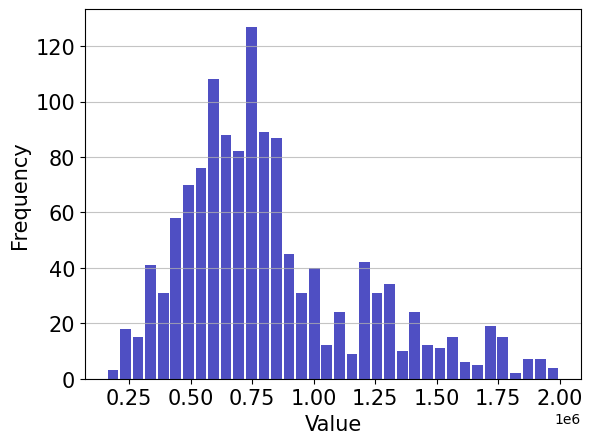

In [262]:
n, bins, patches = plt.hist(x=nyc_df['price'], bins=36, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()



In [263]:
bins

array([ 159000.        ,  210111.11111111,  261222.22222222,
        312333.33333333,  363444.44444444,  414555.55555556,
        465666.66666667,  516777.77777778,  567888.88888889,
        619000.        ,  670111.11111111,  721222.22222222,
        772333.33333333,  823444.44444444,  874555.55555556,
        925666.66666667,  976777.77777778, 1027888.88888889,
       1079000.        , 1130111.11111111, 1181222.22222222,
       1232333.33333333, 1283444.44444444, 1334555.55555556,
       1385666.66666667, 1436777.77777778, 1487888.88888889,
       1539000.        , 1590111.11111111, 1641222.22222222,
       1692333.33333333, 1743444.44444444, 1794555.55555556,
       1845666.66666667, 1896777.77777778, 1947888.88888889,
       1999000.        ])

(array([  5.,  26.,  40.,  43.,  73., 114., 119., 101., 165., 112., 100.,
         43.,  68.,  12.,  24.,  51.,  29.,  36.,  32.,  11.,  14.,  21.,
          3.,  21.,  17.,   4.,  10.,   4.]),
 array([ 159000.        ,  224714.28571429,  290428.57142857,
         356142.85714286,  421857.14285714,  487571.42857143,
         553285.71428571,  619000.        ,  684714.28571429,
         750428.57142857,  816142.85714286,  881857.14285714,
         947571.42857143, 1013285.71428571, 1079000.        ,
        1144714.28571429, 1210428.57142857, 1276142.85714286,
        1341857.14285714, 1407571.42857143, 1473285.71428571,
        1539000.        , 1604714.28571429, 1670428.57142857,
        1736142.85714286, 1801857.14285714, 1867571.42857143,
        1933285.71428571, 1999000.        ]),
 <BarContainer object of 28 artists>)

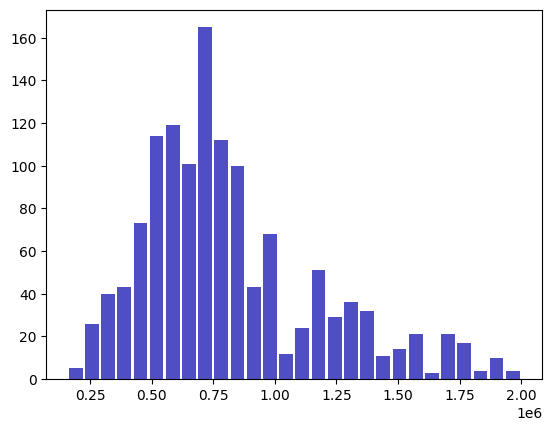

In [264]:
plt.hist(x=nyc_df[nyc_df["price"] < 2000000]["price"], bins=28, color='#0504aa',alpha=0.7, rwidth=0.85)

In [139]:
len(nyc_df[nyc_df["price"] < 2000000])

1307

In [141]:
# Cleaned dataset with outliers removed

nyc_df = nyc_df[nyc_df['price'] < 2000000]

In [143]:
len(nyc_df)

1307

(array([  2.,  16.,  24.,  47.,  62.,  89., 117., 133., 107., 156., 134.,
         60.,  46.,  35.,  26.,  16.,  58.,  42.,  26.,  17.,  14.,  15.,
          7.,  23.,  16.,   5.,  10.,   4.]),
 array([ 120000.        ,  187107.14285714,  254214.28571429,
         321321.42857143,  388428.57142857,  455535.71428571,
         522642.85714286,  589750.        ,  656857.14285714,
         723964.28571429,  791071.42857143,  858178.57142857,
         925285.71428571,  992392.85714286, 1059500.        ,
        1126607.14285714, 1193714.28571429, 1260821.42857143,
        1327928.57142857, 1395035.71428571, 1462142.85714286,
        1529250.        , 1596357.14285714, 1663464.28571429,
        1730571.42857143, 1797678.57142857, 1864785.71428571,
        1931892.85714286, 1999000.        ]),
 <BarContainer object of 28 artists>)

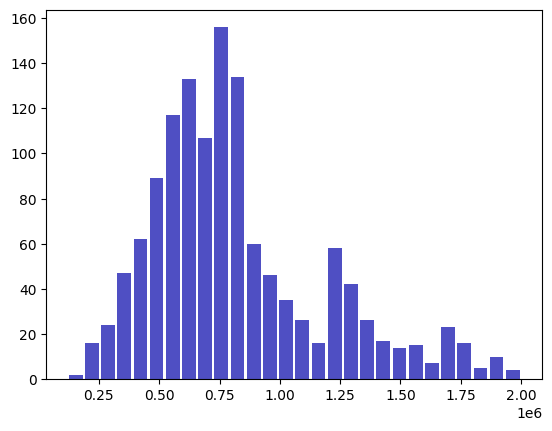

In [144]:
# Final histogram
plt.hist(x=nyc_df["price"], bins=28, color='#0504aa',alpha=0.7, rwidth=0.85)

In [145]:
nyc_df['beds'].unique()

array([ 2,  5,  3,  6,  1,  4,  8,  0, 10,  7,  9, 33, 18, 11],
      dtype=int64)

In [147]:
nyc_df.to_csv('nyc_df.csv', index=False)

In [167]:
nyc_df = pd.read_csv('nyc_df.csv')

In [169]:
nyc_df = pd.get_dummies(nyc_df, columns=['borough'], prefix='borough', drop_first=True, dtype=int)

In [289]:
nyc_df

,price,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland
0,505000.0,2,3,1000.0,0,1,0,0
1,499900.0,5,2,1998.0,0,1,0,0
2,475000.0,2,1,750.0,0,1,0,0
3,1388888.0,3,4,2298.0,0,1,0,0
4,1188000.0,6,6,2550.0,0,1,0,0
...,...,...,...,...,...,...,...,...
1302,949800.0,3,3,1966.0,1,0,0,0
1303,824999.0,7,2,2100.0,1,0,0,0
1304,919000.0,3,3,1880.0,1,0,0,0
1305,725000.0,3,2,1430.0,1,0,0,0


In [221]:
X = nyc_df.drop(columns=['price'])

In [222]:
y = nyc_df['price']

Further data cleaning: removing properties with abnormally large area. 

In [220]:
nyc_df = nyc_df[nyc_df['area'] < 50000]

Splitting data into training and testing subsets, and building our linear model.

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [224]:
reg = linear_model.LinearRegression().fit(X_train, y_train)

Ensuring the test data set aligns with the cleaned full dataset. 

In [198]:
X_test = X_test[X_test['area'] < 50000]

## Visualizations

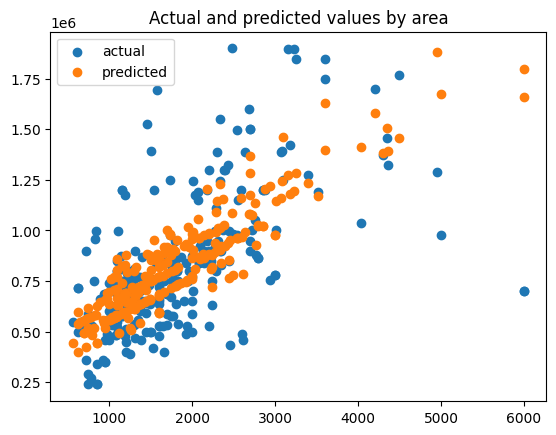

In [245]:
plt.title("Actual and predicted values by area")
plt.scatter(X_test['area'], y_test, label='actual')
plt.scatter(X_test['area'], reg.predict(X_test), label='predicted')
plt.legend()

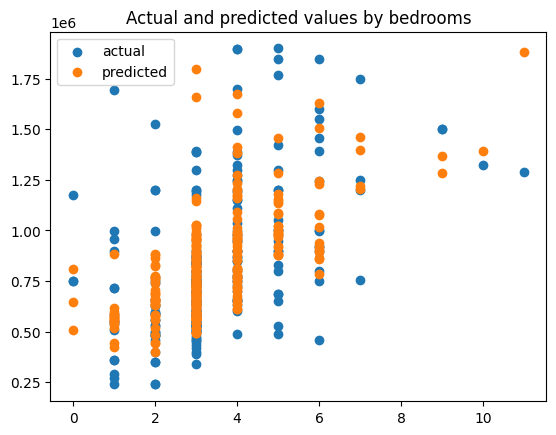

In [246]:
plt.title("Actual and predicted values by bedrooms")
plt.scatter(X_test['beds'], y_test, label='actual')
plt.scatter(X_test['beds'], reg.predict(X_test), label='predicted')
plt.legend()

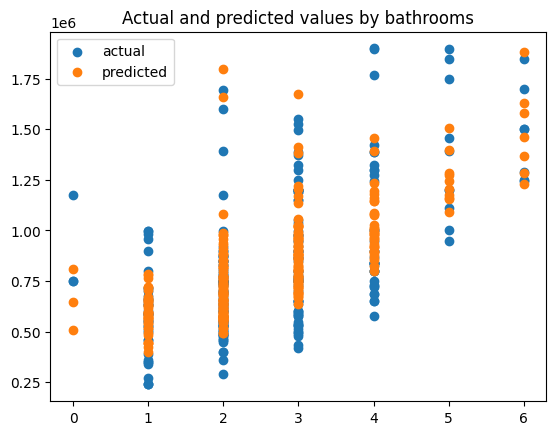

In [248]:
plt.title("Actual and predicted values by bathrooms")
plt.scatter(X_test['baths'], y_test, label='actual')
plt.scatter(X_test['baths'], reg.predict(X_test), label='predicted')
plt.legend()

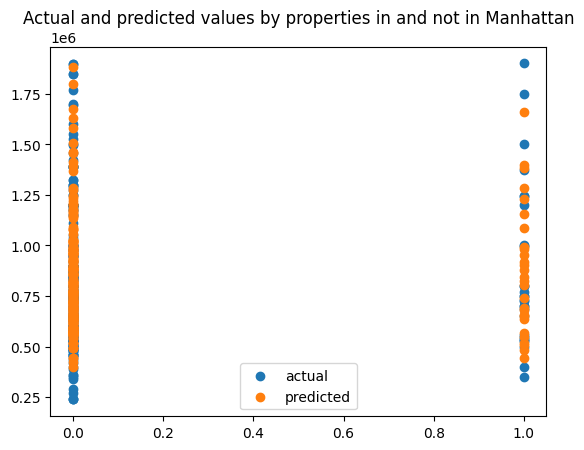

In [252]:
plt.title('Actual and predicted values by properties in and not in Manhattan')
plt.scatter(X_test['borough_manhattan'], y_test, label='actual')
plt.scatter(X_test['borough_manhattan'], reg.predict(X_test), label='predicted')
plt.legend()

The model yields an R-squared value of just over 45%.

In [256]:
print(r2_score(y_test, reg.predict(X_test)))

0.4524562652910473


We can now use the model to determine the expected price of a particular property. Consider several specific properties chosen at random from the test dataset:

In [270]:
prediction_data = X_test.sample(n=10)


In [274]:
prediction_data

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland
1015,3,2,1380.0,1,0,0,0
1016,4,4,3225.0,1,0,0,0
604,5,4,2288.0,0,0,0,1
1173,3,2,1312.0,1,0,0,0
732,3,3,1827.0,0,0,0,1
357,3,1,1316.0,0,0,0,0
30,2,2,2242.0,0,1,0,0
53,4,4,1813.0,0,1,0,0
634,3,2,816.0,0,0,0,1
1116,3,2,1936.0,1,0,0,0


In [275]:
predicted_values = reg.predict(prediction_data)

In [277]:
prediction_data['predicted'] = predicted_values

Below are the predicted prices for each property. We will now add these predicted prices to our prediction dataframe, and add the actual price by joining with the full dataframe.

In [279]:
predicted_values

array([ 635529.09900812, 1195573.89923897,  992588.82172957,
        621228.08293447,  820224.00825766,  669892.12740905,
        877418.87303218,  952154.23403773,  518055.93784163,
        752460.93631617])

In [280]:
prediction_data['predicted'] = prediction_data['predicted'].apply(lambda x: int(x))

In [285]:
prediction_data

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland,predicted
1015,3,2,1380.0,1,0,0,0,635529
1016,4,4,3225.0,1,0,0,0,1195573
604,5,4,2288.0,0,0,0,1,992588
1173,3,2,1312.0,1,0,0,0,621228
732,3,3,1827.0,0,0,0,1,820224
357,3,1,1316.0,0,0,0,0,669892
30,2,2,2242.0,0,1,0,0,877418
53,4,4,1813.0,0,1,0,0,952154
634,3,2,816.0,0,0,0,1,518055
1116,3,2,1936.0,1,0,0,0,752460


In [290]:
prediction_data.merge(nyc_df, how='left')

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland,predicted,price
0,3,2,1380.0,1,0,0,0,635529,459000.0
1,4,4,3225.0,1,0,0,0,1195573,1899000.0
2,5,4,2288.0,0,0,0,1,992588,799999.0
3,5,4,2288.0,0,0,0,1,992588,799999.0
4,3,2,1312.0,1,0,0,0,621228,539000.0
5,3,3,1827.0,0,0,0,1,820224,539000.0
6,3,1,1316.0,0,0,0,0,669892,675000.0
7,2,2,2242.0,0,1,0,0,877418,750000.0
8,4,4,1813.0,0,1,0,0,952154,799000.0
9,3,2,816.0,0,0,0,1,518055,750000.0


Now it is easy to compare the predicted and actual prices for these properties. From this dataframe we can determine which properties are undervalued or overvalued. 